In [1]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import repeat

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor
from sklearn.metrics import mean_squared_error

# Fast Arima
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA,
                                  SeasonalExponentialSmoothing)

C:\Users\SARK\anaconda3\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Assumtion:
Let's say we are at the end of 18 Jan. Our target is the DA LMP for Chicago hub in PJM. We have target, coal gen, oil gen, and gas gen available till the end of 18 Jan. We want to forecast DA LMP for 19, 20 and 21 Jan. Please note that system demand is available for the current day and next 6 day meaning this is available for our forecast periods (19-21 Jan). So this system demand is available for the forecast interval. If we want to use coal, oil or gas gen, we need to use gap filling method so that we can extend these predictors till the end of forecast interval.

In [2]:
# Read the dataframe containing train and forecast timestamps, and the predictors availabe at forecast interval
# This dataframe must be manufactured before doing anything
final_df = pd.read_csv("pjm_price_train_data.csv", parse_dates=["time"])[["time", "chicago_hub_lmp_dam", "coal_gen_rt", "gas_gen_rt", "oil_gen_rt", "system_demand_7da"]]
final_df.head()

,time,chicago_hub_lmp_dam,coal_gen_rt,gas_gen_rt,oil_gen_rt,system_demand_7da
0,2022-01-01 00:00:00,21.6,14600.0,25700.0,230.0,NaN
1,2022-01-01 01:00:00,19.0,14200.0,24300.0,227.0,NaN
2,2022-01-01 02:00:00,18.6,14000.0,24100.0,227.0,NaN
3,2022-01-01 03:00:00,18.7,14000.0,23100.0,227.0,NaN
4,2022-01-01 04:00:00,17.8,14000.0,22500.0,226.0,NaN


In [3]:
# Let's look at the last 5 samples
final_df.tail(5)

,time,chicago_hub_lmp_dam,coal_gen_rt,gas_gen_rt,oil_gen_rt,system_demand_7da
9259,2023-01-21 19:00:00,NaN,NaN,NaN,NaN,98700.0
9260,2023-01-21 20:00:00,NaN,NaN,NaN,NaN,97400.0
9261,2023-01-21 21:00:00,NaN,NaN,NaN,NaN,95200.0
9262,2023-01-21 22:00:00,NaN,NaN,NaN,NaN,92500.0
9263,2023-01-21 23:00:00,NaN,NaN,NaN,NaN,89000.0


In [4]:
# Check the number of missing values by columns
final_df.isna().sum()

time                     0
chicago_hub_lmp_dam     73
coal_gen_rt            236
gas_gen_rt             236
oil_gen_rt             236
system_demand_7da       86
dtype: int64

In [5]:
class Forecast:
    """
    ref_df = main dataframe (fina_df),
    train_start = training start date
    train_end = training end date
    forecast_horizon = number of periods to forecast into the future
    """
    def __init__(self, ref_df, train_start, train_end, forecast_horizon):
        self.ref_df=ref_df
        self.grain=pd.infer_freq(ref_df.set_index("time").index) # Find the grain of the data
        self.train_start=train_start
        self.train_end=train_end
        self.forecast_horizon=forecast_horizon
        
        # Create train df with time only
        self.train_df = pd.DataFrame({
            "time":pd.date_range(start=train_start, end=self.train_end, freq=self.grain)
        })
        
        # Create forecast df with time only
        self.forecast_df = pd.DataFrame({
            "time":pd.date_range(start=pd.to_datetime(self.train_end)+pd.Timedelta(value=1, unit=self.grain),
                                 periods=forecast_horizon, freq=self.grain)
        })
        
        # Merge train and forecast df
        self.merged_df = pd.concat([self.train_df, self.forecast_df]).reset_index(drop=True)
    
    # Add the target to the dataframe
    def add_target(self, target):
        self.target=target
        return pd.merge(self.merged_df, self.ref_df[[target, "time"]], on="time", how="left")
    
    # Add features to the dataframe
    def add_features(self, df, features):
        return pd.merge(df, self.ref_df.set_index("time")[features].reset_index(), on="time", how="left")
    
    # Apply gap filling method on a feature or target
    def fill_gap(self, df, col_name, method):
        if method=="forward_fill":
            df[col_name] = df[col_name].fillna(method="ffill")
            return df
        
        if method=="backward_fill":
            df[col_name] = df[col_name].fillna(method="bfill")
            return df
        
        if method=="linear_interpolation":
            df[col_name] = df[col_name].interpolate(limit_area="inside") # Won't use ffill
            return df
    
    # Add builtins (time related features) into the dataframe
    def add_builtins(self, df, builtin):
        if builtin=="hour":
            df["hour"] = df.time.dt.hour
            
        if builtin=="month":
            df["month"] = df.time.dt.month
            
        if builtin=="day":
            df["day"] = df.time.dt.day_of_week
        return df
    
    # Add lagged predictor into the dataframe
    def add_lags(self, df, col_name, lag_size):
        self.lag_size=lag_size
        with_lag = df
        with_lag[col_name] = with_lag[self.target].shift(lag_size)
        return with_lag
    
    # Add rolling avg as a predictor
    def add_rolling_avg(self, df, col_name, rolling_avg_size):
        self.rolling_avg_size=rolling_avg_size
        with_sma = df
        with_sma[col_name] = with_sma[self.target].rolling(rolling_avg_size).mean().shift()
        return with_sma
    
    # Add rolling std as a predictor
    def add_rolling_std(self, df, col_name, rolling_std_size):
        self.rolling_std_size=rolling_std_size
        with_smstd = df
        with_smstd[col_name] = with_smstd[self.target].rolling(rolling_std_size).std().shift()
        return with_smstd
    
    # Get the trained model (ml or statistical)
    def get_trained_model(self, df, model_type, model):
        self.model=model
        self.model_type=model_type
        
        train_df = df[df.time.between(self.train_start, self.train_end)].dropna().set_index("time")
        forecast_df = df[df.time>=self.forecast_df.time.iloc[0]].drop(self.target, axis=1).set_index("time")
        
        if model_type=="ml":
            model.fit(train_df.iloc[:, 1:].query("index<=@self.train_end"),
                  train_df.loc[:, self.target].to_frame().query("index<=@self.train_end"))
            return model, pd.concat([train_df, forecast_df])
        
        if model_type=="statistical":
            train_df = train_df.reset_index()
            train_df.insert(loc=0, column="unique_id", value="x")
            train_df = train_df.rename(columns={self.target:"y", "time":"ds"})

            forecast_df = forecast_df.reset_index()
            forecast_df.insert(loc=0, column="unique_id", value="y")
            forecast_df = forecast_df.rename(columns={"time":"ds"})
            sf = StatsForecast(models = [model],
                               freq = self.grain,
                               n_jobs=-1,
                               df=train_df)
            sf.fit(train_df)
            return sf, forecast_df
    
    # Make forecast using the trained model (ml or ststistical)
    def make_forecast(self, forecast_date, trained_model, df):
        if self.model_type=="ml":
            if "pp" in df.columns:
                pp_over = pd.to_datetime(forecast_date)-pd.Timedelta(self.lag_size, self.grain)
                df.at[forecast_date, "pp"] = df[df.index==pp_over][self.target]

            if "rolling_avg" in df.columns:
                sma_over = pd.to_datetime(forecast_date)-pd.Timedelta(self.rolling_avg_size, self.grain)
                df.at[forecast_date, "rolling_avg"] = df[df.index>=sma_over].head(self.rolling_avg_size)[self.target].mean()

            if "rolling_std" in df.columns:
                smstd_over = pd.to_datetime(forecast_date)-pd.Timedelta(self.rolling_std_size, self.grain)
                df.at[forecast_date, "rolling_std"] = df[df.index>=smstd_over].head(self.rolling_std_size)[self.target].std()

            pred = trained_model.predict(df.query("index==@forecast_date").iloc[:, 1:])
            df.at[forecast_date, self.target] = pred
            return df
        
        if self.model_type=="statistical":
            pred = trained_model.predict(h=self.forecast_horizon, X_df=df).reset_index(drop=True).iloc[:, -1].to_frame()
            pred.columns = ["forecast"]
            return pred

#### 1. XGBoost

XGBoost rmse: 4.404458407424114


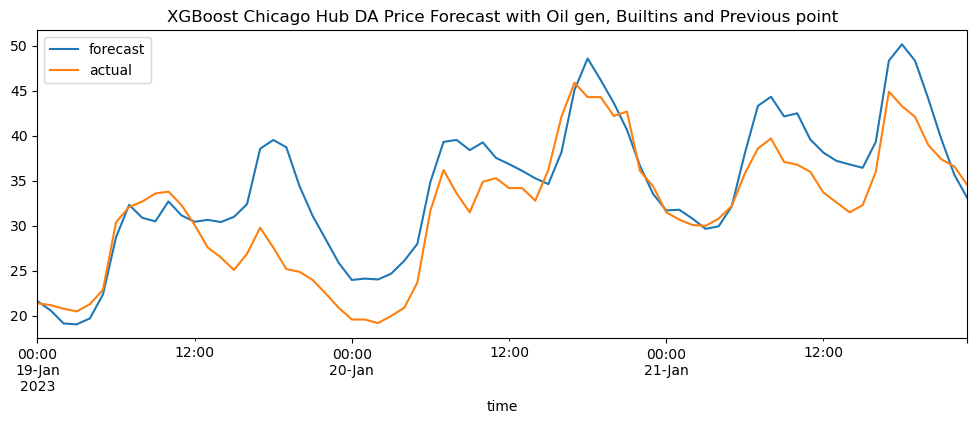

In [6]:
f = Forecast(
     ref_df=final_df,
     train_start="2022-01-01 00:00:00",
     train_end="2023-01-18 23:00:00",
     forecast_horizon=72)

df = f.add_target("chicago_hub_lmp_dam")
df = f.fill_gap(df, "chicago_hub_lmp_dam", "linear_interpolation")

# df = f.add_features(df, "system_demand_7da")
# df = f.fill_gap(df, "system_demand_7da", "linear_interpolation")

df = f.add_features(df, "oil_gen_rt")
df = f.fill_gap(df, "oil_gen_rt", "forward_fill")

df = f.add_builtins(df, "hour")
df = f.add_builtins(df, "month")

df = f.add_lags(df, "pp", 1)
# df = f.add_rolling_avg(df, "rolling_avg", 4)
# df = f.add_rolling_std(df, "rolling_std", 4)

m, df = f.get_trained_model(df, model_type="ml", model=XGBRegressor(random_state=43))

dates = df[df.index>="2023-01-19 00:00:00"].index
df = pd.concat(list(map(f.make_forecast, dates, repeat(m), repeat(df))))
df = df[~df.index.duplicated(keep="first")] # Very important, drops duplicates by index

forecast = df[df.index>="2023-01-19 00:00:00"].rename(columns={"chicago_hub_lmp_dam":"forecast"})
test = pd.read_csv("pjm_price_test_data.csv", parse_dates=["time"]).set_index("time").rename(columns={"chicago_hub_lmp_dam":"actual"})
m = pd.concat([forecast, test], axis=1)[["forecast", "actual"]]
rmse = mean_squared_error(m.actual, m.forecast, squared=False)
print(f"XGBoost rmse: {rmse}")
m.plot(title="XGBoost Chicago Hub DA Price Forecast with Oil gen, Builtins and Previous point", figsize=(12, 4))
plt.show()

XGBoost rmse: 6.863761195993711


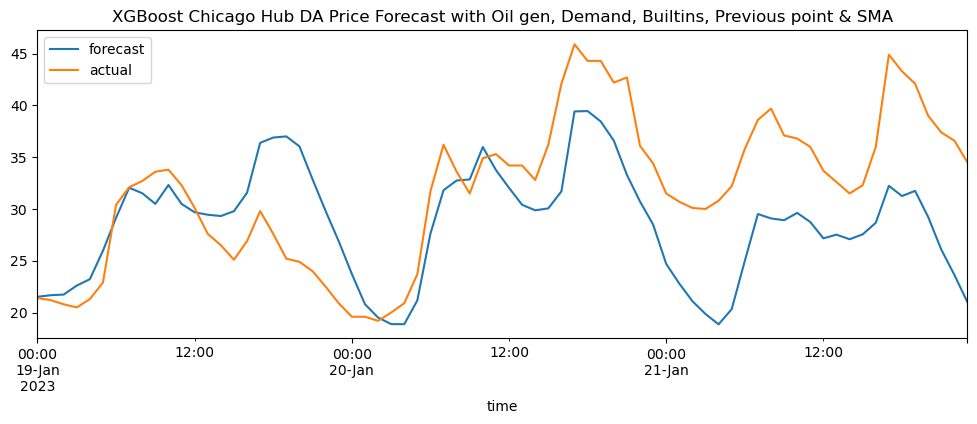

In [7]:
f = Forecast(
     ref_df=final_df,
     train_start="2022-01-01 00:00:00",
     train_end="2023-01-18 23:00:00",
     forecast_horizon=72)

df = f.add_target("chicago_hub_lmp_dam")
df = f.fill_gap(df, "chicago_hub_lmp_dam", "linear_interpolation")

df = f.add_features(df, "system_demand_7da")
df = f.fill_gap(df, "system_demand_7da", "linear_interpolation")

df = f.add_features(df, "oil_gen_rt")
df = f.fill_gap(df, "oil_gen_rt", "forward_fill")

df = f.add_builtins(df, "hour")
df = f.add_builtins(df, "month")

df = f.add_lags(df, "pp", 1)
df = f.add_rolling_avg(df, "rolling_avg", 4)
# df = f.add_rolling_std(df, "rolling_std", 4)

m, df = f.get_trained_model(df, model_type="ml", model=XGBRegressor(random_state=43))

dates = df[df.index>="2023-01-19 00:00:00"].index
df = pd.concat(list(map(f.make_forecast, dates, repeat(m), repeat(df))))
df = df[~df.index.duplicated(keep="first")] # Very important, drops duplicates by index

forecast = df[df.index>="2023-01-19 00:00:00"].rename(columns={"chicago_hub_lmp_dam":"forecast"})
test = pd.read_csv("pjm_price_test_data.csv", parse_dates=["time"]).set_index("time").rename(columns={"chicago_hub_lmp_dam":"actual"})
m = pd.concat([forecast, test], axis=1)[["forecast", "actual"]]
rmse = mean_squared_error(m.actual, m.forecast, squared=False)
print(f"XGBoost rmse: {rmse}")
m.plot(title="XGBoost Chicago Hub DA Price Forecast with Oil gen, Demand, Builtins, Previous point & SMA", figsize=(12, 4))
plt.show()

- Let's increase the lag size and sma window to 24

XGBoost rmse: 5.640066475447515


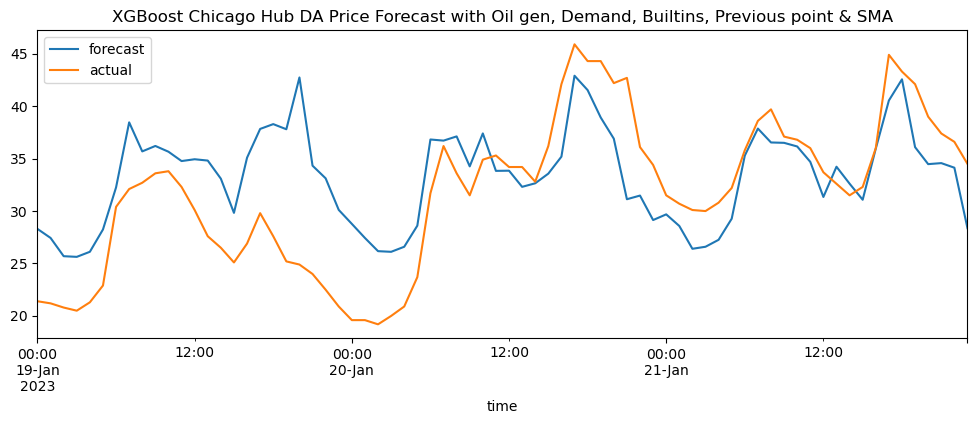

In [8]:
f = Forecast(
     ref_df=final_df,
     train_start="2022-01-01 00:00:00",
     train_end="2023-01-18 23:00:00",
     forecast_horizon=72)

df = f.add_target("chicago_hub_lmp_dam")
df = f.fill_gap(df, "chicago_hub_lmp_dam", "linear_interpolation")

df = f.add_features(df, "system_demand_7da")
df = f.fill_gap(df, "system_demand_7da", "linear_interpolation")

df = f.add_features(df, "oil_gen_rt")
df = f.fill_gap(df, "oil_gen_rt", "forward_fill")

df = f.add_builtins(df, "hour")
df = f.add_builtins(df, "month")

df = f.add_lags(df, "pp", 24)
df = f.add_rolling_avg(df, "rolling_avg", 24)
# df = f.add_rolling_std(df, "rolling_std", 4)

m, df = f.get_trained_model(df, model_type="ml", model=XGBRegressor(random_state=43))

dates = df[df.index>="2023-01-19 00:00:00"].index
df = pd.concat(list(map(f.make_forecast, dates, repeat(m), repeat(df))))
df = df[~df.index.duplicated(keep="first")] # Very important, drops duplicates by index

forecast = df[df.index>="2023-01-19 00:00:00"].rename(columns={"chicago_hub_lmp_dam":"forecast"})
test = pd.read_csv("pjm_price_test_data.csv", parse_dates=["time"]).set_index("time").rename(columns={"chicago_hub_lmp_dam":"actual"})
m = pd.concat([forecast, test], axis=1)[["forecast", "actual"]]
rmse = mean_squared_error(m.actual, m.forecast, squared=False)
print(f"XGBoost rmse: {rmse}")
m.plot(title="XGBoost Chicago Hub DA Price Forecast with Oil gen, Demand, Builtins, Previous point & SMA", figsize=(12, 4))
plt.show()

#### 2. CatBoost

CatBoost rmse: 5.712861355254227


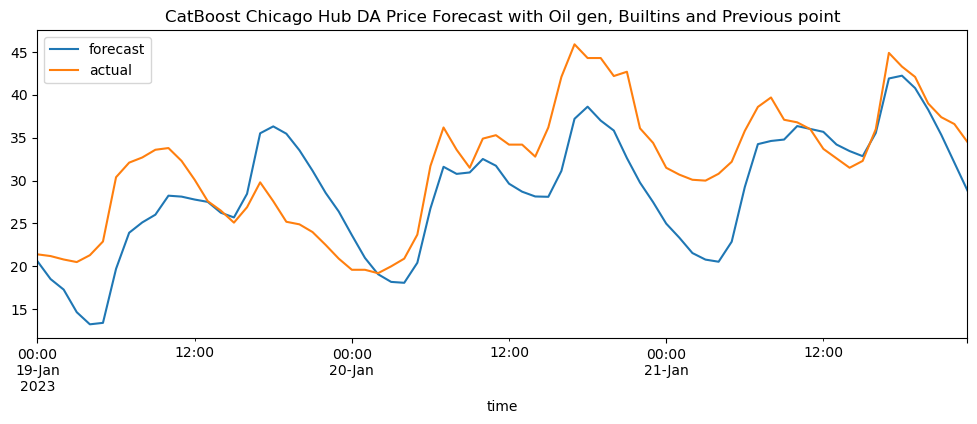

In [9]:
f = Forecast(
     ref_df=final_df,
     train_start="2022-01-01 00:00:00",
     train_end="2023-01-18 23:00:00",
     forecast_horizon=72)

df = f.add_target("chicago_hub_lmp_dam")
df = f.fill_gap(df, "chicago_hub_lmp_dam", "linear_interpolation")

# df = f.add_features(df, "system_demand_7da")
# df = f.fill_gap(df, "system_demand_7da", "linear_interpolation")

df = f.add_features(df, "oil_gen_rt")
df = f.fill_gap(df, "oil_gen_rt", "forward_fill")

df = f.add_builtins(df, "hour")
df = f.add_builtins(df, "month")

df = f.add_lags(df, "pp", 1)
# df = f.add_rolling_avg(df, "rolling_avg", 4)
# df = f.add_rolling_std(df, "rolling_std", 4)

m, df = f.get_trained_model(df, model_type="ml", model=CatBoostRegressor(random_state=43, logging_level="Silent"))

dates = df[df.index>="2023-01-19 00:00:00"].index
df = pd.concat(list(map(f.make_forecast, dates, repeat(m), repeat(df))))
df = df[~df.index.duplicated(keep="first")] # Very important, drops duplicates by index

forecast = df[df.index>="2023-01-19 00:00:00"].rename(columns={"chicago_hub_lmp_dam":"forecast"})
test = pd.read_csv("pjm_price_test_data.csv", parse_dates=["time"]).set_index("time").rename(columns={"chicago_hub_lmp_dam":"actual"})
m = pd.concat([forecast, test], axis=1)[["forecast", "actual"]]
rmse = mean_squared_error(m.actual, m.forecast, squared=False)
print(f"CatBoost rmse: {rmse}")
m.plot(title="CatBoost Chicago Hub DA Price Forecast with Oil gen, Builtins and Previous point", figsize=(12, 4))
plt.show()

#### 3. LGBM
Let's try everything inclusing rolling avg and rolling standard deviation

LGBM rmse: 8.282554885055514


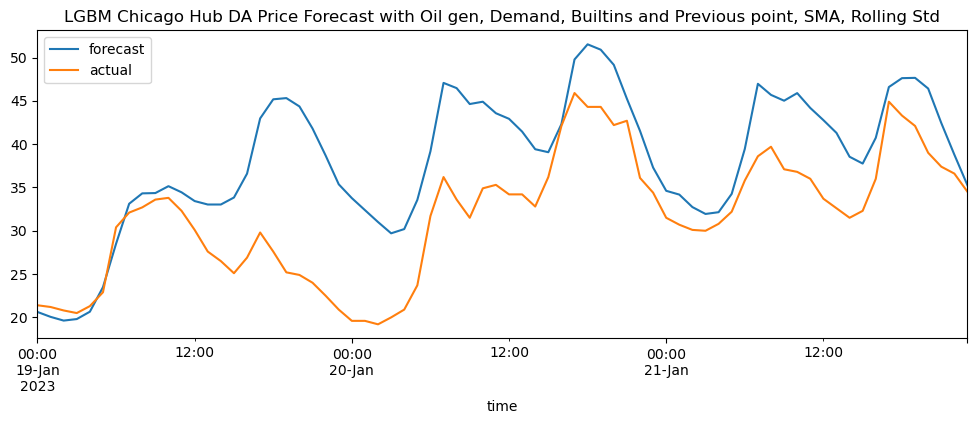

In [10]:
f = Forecast(
     ref_df=final_df,
     train_start="2022-01-01 00:00:00",
     train_end="2023-01-18 23:00:00",
     forecast_horizon=72)

df = f.add_target("chicago_hub_lmp_dam")
df = f.fill_gap(df, "chicago_hub_lmp_dam", "linear_interpolation")

df = f.add_features(df, "system_demand_7da")
df = f.fill_gap(df, "system_demand_7da", "linear_interpolation")

df = f.add_features(df, "oil_gen_rt")
df = f.fill_gap(df, "oil_gen_rt", "forward_fill")

df = f.add_builtins(df, "hour")
df = f.add_builtins(df, "month")

df = f.add_lags(df, "pp", 1)
df = f.add_rolling_avg(df, "rolling_avg", 4)
df = f.add_rolling_std(df, "rolling_std", 4)

m, df = f.get_trained_model(df, model_type="ml", model=LGBMRegressor(random_state=43))

dates = df[df.index>="2023-01-19 00:00:00"].index
df = pd.concat(list(map(f.make_forecast, dates, repeat(m), repeat(df))))
df = df[~df.index.duplicated(keep="first")] # Very important, drops duplicates by index

forecast = df[df.index>="2023-01-19 00:00:00"].rename(columns={"chicago_hub_lmp_dam":"forecast"})
test = pd.read_csv("pjm_price_test_data.csv", parse_dates=["time"]).set_index("time").rename(columns={"chicago_hub_lmp_dam":"actual"})
m = pd.concat([forecast, test], axis=1)[["forecast", "actual"]]
rmse = mean_squared_error(m.actual, m.forecast, squared=False)
print(f"LGBM rmse: {rmse}")
m.plot(title="LGBM Chicago Hub DA Price Forecast with Oil gen, Demand, Builtins and Previous point, SMA, Rolling Std", figsize=(12, 4))
plt.show()

#### 4. NGBoost

C:\Users\SARK\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


NGBoost rmse: 10.329613429352586


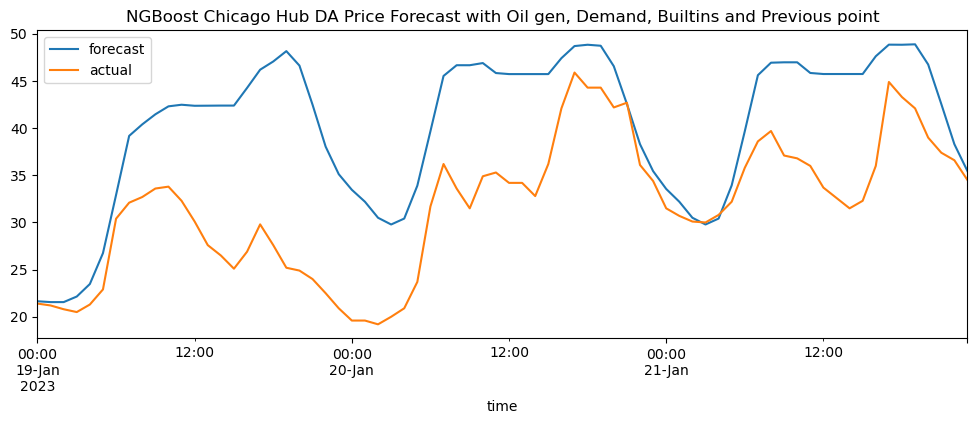

In [11]:
f = Forecast(
     ref_df=final_df,
     train_start="2022-01-01 00:00:00",
     train_end="2023-01-18 23:00:00",
     forecast_horizon=72)

df = f.add_target("chicago_hub_lmp_dam")
df = f.fill_gap(df, "chicago_hub_lmp_dam", "linear_interpolation")

df = f.add_features(df, "system_demand_7da")
df = f.fill_gap(df, "system_demand_7da", "linear_interpolation")

# df = f.add_features(df, "oil_gen_rt")
# df = f.fill_gap(df, "oil_gen_rt", "forward_fill")

df = f.add_builtins(df, "hour")
df = f.add_builtins(df, "month")

df = f.add_lags(df, "pp", 1)
# df = f.add_rolling_avg(df, "rolling_avg", 4)
# df = f.add_rolling_std(df, "rolling_std", 4)

m, df = f.get_trained_model(df, model_type="ml", model=NGBRegressor(random_state=43, verbose=False))

dates = df[df.index>="2023-01-19 00:00:00"].index
df = pd.concat(list(map(f.make_forecast, dates, repeat(m), repeat(df))))
df = df[~df.index.duplicated(keep="first")] # Very important, drops duplicates by index

forecast = df[df.index>="2023-01-19 00:00:00"].rename(columns={"chicago_hub_lmp_dam":"forecast"})
test = pd.read_csv("pjm_price_test_data.csv", parse_dates=["time"]).set_index("time").rename(columns={"chicago_hub_lmp_dam":"actual"})
m = pd.concat([forecast, test], axis=1)[["forecast", "actual"]]
rmse = mean_squared_error(m.actual, m.forecast, squared=False)
print(f"NGBoost rmse: {rmse}")
m.plot(title="NGBoost Chicago Hub DA Price Forecast with Oil gen, Demand, Builtins and Previous point", figsize=(12, 4))
plt.show()

#### 5. ARIMA
Note: Right now, pp, rolling avg and rolling std can not be used with statistical forecast

C:\Users\SARK\anaconda3\lib\site-packages\statsforecast\arima.py:1562: UserWarning: xreg not required by this model, ignoring the provided regressors
  warnings.warn(


ARIMA rmse: 6.0647879951326535


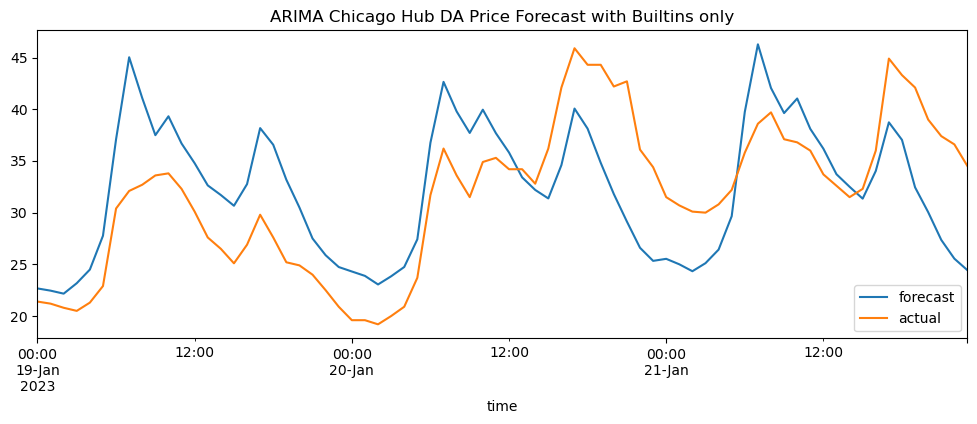

In [12]:
f = Forecast(
     ref_df=final_df,
     train_start="2023-01-01 00:00:00",
     train_end="2023-01-18 23:00:00",
     forecast_horizon=72)

df = f.add_target("chicago_hub_lmp_dam")
df = f.fill_gap(df, "chicago_hub_lmp_dam", "linear_interpolation")

# df = f.add_features(df, "system_demand_7da")
# df = f.fill_gap(df, "system_demand_7da", "linear_interpolation")

# df = f.add_features(df, "oil_gen_rt")
# df = f.fill_gap(df, "oil_gen_rt", "forward_fill")

df = f.add_builtins(df, ["hour", "month"])

m, df = f.get_trained_model(df, model_type="statistical", model=AutoARIMA(season_length=24))
forecast = f.make_forecast("2023-01-19 00:00:00", m, df)

test = pd.read_csv("pjm_price_test_data.csv", parse_dates=["time"]).rename(columns={"chicago_hub_lmp_dam":"actual"})
m = pd.concat([forecast, test], axis=1)[["forecast", "actual", "time"]].set_index("time")
rmse = mean_squared_error(m.actual, m.forecast, squared=False)
print(f"ARIMA rmse: {rmse}")
m.plot(title="ARIMA Chicago Hub DA Price Forecast with Builtins only", figsize=(12, 4))
plt.show()

- ARIMA with Oil gen

ARIMA rmse: 10.967719624981077


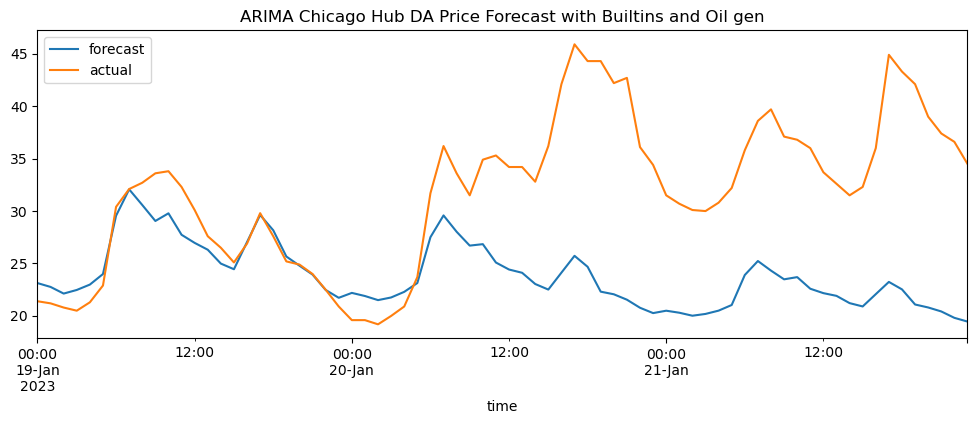

In [13]:
f = Forecast(
     ref_df=final_df,
     train_start="2023-01-01 00:00:00",
     train_end="2023-01-18 23:00:00",
     forecast_horizon=72)

df = f.add_target("chicago_hub_lmp_dam")
df = f.fill_gap(df, "chicago_hub_lmp_dam", "linear_interpolation")

# df = f.add_features(df, "system_demand_7da")
# df = f.fill_gap(df, "system_demand_7da", "linear_interpolation")

df = f.add_features(df, "oil_gen_rt")
df = f.fill_gap(df, "oil_gen_rt", "forward_fill")

df = f.add_builtins(df, ["hour", "month"])

m, df = f.get_trained_model(df, model_type="statistical", model=AutoARIMA(season_length=24))
forecast = f.make_forecast("2023-01-19 00:00:00", m, df)

test = pd.read_csv("pjm_price_test_data.csv", parse_dates=["time"]).rename(columns={"chicago_hub_lmp_dam":"actual"})
m = pd.concat([forecast, test], axis=1)[["forecast", "actual", "time"]].set_index("time")
rmse = mean_squared_error(m.actual, m.forecast, squared=False)
print(f"ARIMA rmse: {rmse}")
m.plot(title="ARIMA Chicago Hub DA Price Forecast with Builtins and Oil gen", figsize=(12, 4))
plt.show()

#### 6. Seasonal Expontial Smoothing

SES rmse: 5.839924561494716


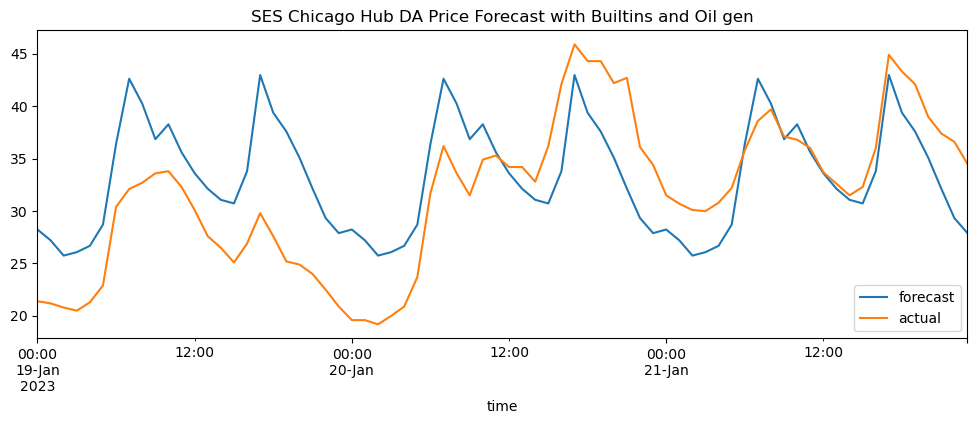

In [14]:
f = Forecast(
     ref_df=final_df,
     train_start="2023-01-01 00:00:00",
     train_end="2023-01-18 23:00:00",
     forecast_horizon=72)

df = f.add_target("chicago_hub_lmp_dam")
df = f.fill_gap(df, "chicago_hub_lmp_dam", "linear_interpolation")

m, df = f.get_trained_model(df, model_type="statistical", model=SeasonalExponentialSmoothing(season_length=24, alpha=0.2))
forecast = f.make_forecast("2023-01-19 00:00:00", m, df)

test = pd.read_csv("pjm_price_test_data.csv", parse_dates=["time"]).rename(columns={"chicago_hub_lmp_dam":"actual"})
m = pd.concat([forecast, test], axis=1)[["forecast", "actual", "time"]].set_index("time")
rmse = mean_squared_error(m.actual, m.forecast, squared=False)
print(f"SES rmse: {rmse}")
m.plot(title="SES Chicago Hub DA Price Forecast with Builtins and Oil gen", figsize=(12, 4))
plt.show()